## Курсовой проект

#### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

#### Загрузка данных

In [4]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

#### Уменьшение использования памяти

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
train_df['Rooms'] = train_df['Rooms'].astype(np.int64)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(np.int64)
test_df['Rooms'] = test_df['Rooms'].astype(np.int64)
test_df['HouseFloor'] = test_df['HouseFloor'].astype(np.int64)

In [7]:
reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.43 MB
Decreased by 71.8%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3,115.027313,NaN,10.0,4,10,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1,39.832523,23.169222,8.0,7,8,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3,78.342216,47.671970,10.0,2,17,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1,40.409908,NaN,1.0,10,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2,64.285065,38.562515,9.0,16,16,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2,49.090729,33.272625,6.0,3,12,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2,64.307686,37.038422,9.0,13,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1,29.648056,16.555363,5.0,3,5,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1,32.330292,22.326870,5.0,3,9,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


In [8]:
reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.19 MB
Decreased by 74.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1,36.847630,19.094183,5.0,5,9,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1,42.493908,42.568134,10.0,7,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2,59.463676,NaN,9.0,19,19,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3,49.646030,33.893826,6.0,2,2,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1,53.837055,NaN,1.0,8,17,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2,43.177521,30.339945,5.0,6,5,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3,93.698120,94.521461,10.0,21,27,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1,33.656723,19.003260,5.0,2,5,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1,38.635155,20.976257,9.0,8,14,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


#### Вычисление статистик на обучающей выборке

In [9]:
medians = train_df[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Healthcare_1']].median()
medians

Rooms              2.000000
Square            52.513309
LifeSquare        32.781261
KitchenSquare      6.000000
Healthcare_1     900.000000
dtype: float64

#### Предобработка данных

In [10]:
train_df.loc[(train_df['Rooms'] > 6) | (train_df['Rooms'] == 0), 'Rooms'] = medians['Rooms']

In [11]:
train_df.loc[(train_df['Square'] < train_df['Square'].quantile(.975)) |
             (train_df['Square'] > train_df['Square'].quantile(.025)), 'Square'] = medians['Square']

train_df.loc[(train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.975)) |
             (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.025)), 'LifeSquare'] = medians['LifeSquare']

train_df.loc[(train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.975)) |
             (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.025)), 'KitchenSquare'] = medians['KitchenSquare']


In [12]:
floor_out = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

In [13]:
train_df.loc[floor_out, 'Floor'] = train_df.loc[floor_out, 'HouseFloor'].apply(lambda x: random.randint(0, x))

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int64   
 7   HouseFloor     10000 non-null  int8    
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [15]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

#### Обучение модели

Фичи для обучения были подобраны опытным путем по влиянию на качество результата моделирования.

In [16]:
y = train_df['Price']
x = train_df.drop(['Id', 'Square', 'KitchenSquare', 'Ecology_2', 'Ecology_3', 'Social_1', 'Healthcare_1', 'Helthcare_2', 
                   'Shops_1', 'Shops_2', 'Price'], axis=1)

scaler = StandardScaler()
stand_features = scaler.fit_transform(x)
x = pd.DataFrame(stand_features, columns=x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 21)

In [17]:
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1)

#### Оценка качества модели

In [18]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.946
Test R2:	0.691


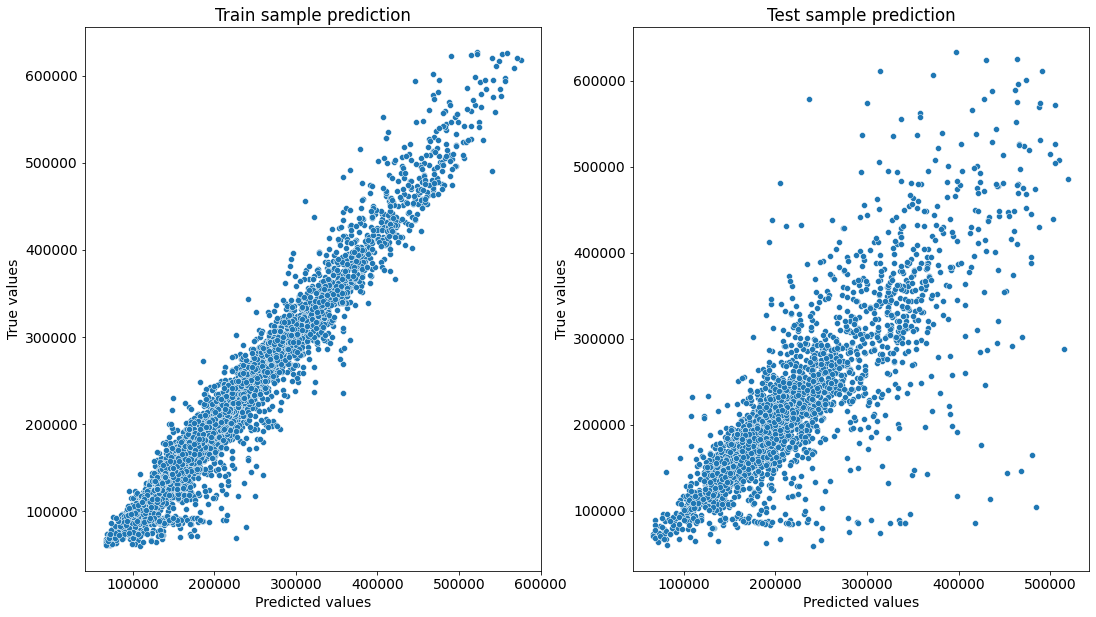

In [19]:
train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

#### Предобработка тестовых данных

In [20]:
test_df.loc[(test_df['Rooms'] > 6) | (test_df['Rooms'] == 0), 'Rooms'] = medians['Rooms']

In [21]:
test_df.loc[(test_df['Square'] < test_df['Square'].quantile(.975)) |
             (test_df['Square'] > test_df['Square'].quantile(.025)), 'Square'] = medians['Square']

test_df.loc[(test_df['LifeSquare'] < test_df['LifeSquare'].quantile(.975)) |
             (test_df['LifeSquare'] > test_df['LifeSquare'].quantile(.025)), 'LifeSquare'] = medians['LifeSquare']

test_df.loc[(test_df['KitchenSquare'] < test_df['KitchenSquare'].quantile(.975)) |
             (test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(.025)), 
            'KitchenSquare'] = medians['KitchenSquare']


In [22]:
floor_out = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

In [23]:
test_df.loc[floor_out, 'Floor'] = test_df.loc[floor_out, 'HouseFloor'].apply(lambda x: random.randint(0, x))

In [24]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = medians['LifeSquare']
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = medians['Healthcare_1']

#### Прогноз по тестовым данным

In [25]:
x = test_df.drop(['Id', 'Square', 'KitchenSquare', 'Ecology_2', 'Ecology_3', 'Social_1', 'Healthcare_1', 'Helthcare_2', 
                   'Shops_1', 'Shops_2'], axis=1)

stand_features = scaler.fit_transform(x)
x = pd.DataFrame(stand_features, columns=x.columns)
price = forest.predict(x)
test_df['price_pred'] = price

In [26]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,price_pred
0,4567,44,1,52.513309,32.781261,6.0,5,9,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B,184652.850703
1,5925,62,1,52.513309,32.781261,6.0,7,17,2017,0.072158,B,B,2,629,1,900.0,0,0,A,136698.521246
2,960,27,2,52.513309,32.781261,6.0,19,19,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,145974.063019
3,3848,23,3,52.513309,32.781261,6.0,2,2,1965,0.014073,B,B,2,475,0,900.0,0,0,B,197231.318484
4,746,74,1,52.513309,32.781261,6.0,8,17,1977,0.309479,B,B,35,7715,4,990.0,0,6,B,193096.502891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2,52.513309,32.781261,6.0,3,5,1962,0.069660,B,B,31,6119,4,900.0,1,2,B,216305.878125
4996,16138,38,3,52.513309,32.781261,6.0,21,27,2018,0.060753,B,B,15,2787,2,520.0,0,7,B,431906.630156
4997,3912,101,1,52.513309,32.781261,6.0,2,5,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B,180837.119062
4998,5722,10,1,52.513309,32.781261,6.0,8,14,1970,0.089040,B,B,33,7976,5,900.0,0,11,B,220888.691406


In [27]:
test_df.to_csv('AZacepin_predictions.csv')